In [27]:
# fourbar.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, HTMLWriter

class FourBarLinkage:
    """
    A class to model and simulate a planar four-bar linkage with ground pivots at D=(0,0) and B=(L_BD,0).

    Link naming:
        - AB: link between joint A and fixed ground joint B
        - AC: coupler between moving joints A and C
        - CD: crank, rotates about fixed ground joint D
        - BD: ground link between fixed joints B and D

    Assumptions:
        - D is fixed at (0,0).
        - B is fixed at (L_BD, 0).
        - All link lengths are positive reals.
        - Crank angle θ_CD is measured from the positive x-axis, CCW, in radians.

    Usage example:

        from fourbar import FourBarLinkage
        linkage = FourBarLinkage(L_AB=3.0, L_AC=4.0, L_CD=2.0, L_BD=5.0)
        linkage.validate_geometry()
        print("Type:", linkage.grashof_type())
        linkage.sweep(n_steps=360)
        linkage.plot_trajectory()
        linkage.plot_joint_angles()
        # linkage.animate(interval=30, save_path="fourbar.mp4")
    """

    def __init__(self, L_AB, L_AC, L_CD, L_BD):
        """
        Initialize a four-bar linkage with given link lengths.

        Parameters
        ----------
        L_AB : float
            Length of link AB (moving link from B to A).
        L_AC : float
            Length of coupler link AC (between moving joints A and C).
        L_CD : float
            Length of crank CD (driving link from D to C).
        L_BD : float
            Length of ground link BD (between fixed ground joints B and D).

        Note
        ----
        - Fixed pivot D is at (0,0).
        - Fixed pivot B is at (L_BD, 0).
        - Crank angle θ_CD is measured CCW from +x-axis.
        """
        # Store link lengths
        self.L_AB = float(L_AB)
        self.L_AC = float(L_AC)
        self.L_CD = float(L_CD)
        self.L_BD = float(L_BD)

        # Fixed pivot coordinates
        self.D = np.array([0.0, 0.0])
        self.B = np.array([self.L_BD, 0.0])

        # After calling sweep(), these arrays will be filled:
        self.theta_list = None  # list of crank angles used
        self.A_positions = None  # shape (N, 2)
        self.C_positions = None  # shape (N, 2)
        self.valid = False
        self._A_branches = None  # +1 or -1 selection at each step

        # After sweep, these will be computed:
        self.joint_angle_A = None  # interior angle at A vs. θ_CD
        self.joint_angle_C = None  # interior angle at C vs. θ_CD

        # Check basic quadrilateral inequality (longest < sum(other three)):
        self.validate_geometry()

    def validate_geometry(self):
        """
        Validate that the four links satisfy the quadrilateral‐closure inequality:
            max < sum(other three).

        Raises
        ------
        ValueError
            If the longest link is >= sum of the other three, meaning no closed pose exists.
        """
        lengths = [self.L_AB, self.L_AC, self.L_CD, self.L_BD]
        lengths_sorted = sorted(lengths)
        if lengths_sorted[-1] >= sum(lengths_sorted[:-1]):
            raise ValueError(
                f"Link lengths {lengths} cannot form a closed quadrilateral "
                "(longest link ≥ sum of the other three)."
            )
        # If passed, geometry is potentially valid. Do not declare success yet.
        self.valid = True

    def _circle_intersection(self, center1, R1, center2, R2):
        """
        Compute the two intersection points of circles:
            ‖X - center1‖ = R1
            ‖X - center2‖ = R2

        Parameters
        ----------
        center1 : array_like, shape (2,)
            (x, y) of circle 1 center.
        R1 : float
            Radius of circle 1.
        center2 : array_like, shape (2,)
            (x, y) of circle 2 center.
        R2 : float
            Radius of circle 2.

        Returns
        -------
        pts : list of numpy arrays
            A list with 0, 1, or 2 intersection points. If no solutions, empty list.
            If one solution (tangent), returns a single-element list [P].

        Notes
        -----
        Implements standard two‐circle‐intersection formula.
        """
        C1 = np.array(center1, dtype=float)
        C2 = np.array(center2, dtype=float)
        d_vec = C2 - C1
        d = np.linalg.norm(d_vec)

        # No intersection if circles too far apart or one inside the other
        if d > R1 + R2 or d < abs(R1 - R2):
            return []

        # If exactly tangent (h = 0), one solution at midpoint
        a = (R1**2 - R2**2 + d**2) / (2 * d)
        h_sq = R1**2 - a**2
        if np.isclose(h_sq, 0.0, atol=1e-12):
            # one solution
            P = C1 + a * (d_vec / d)
            return [P]

        # Two solutions
        h = np.sqrt(h_sq)
        P_mid = C1 + a * (d_vec / d)
        # unit‐perpendicular to (C2 - C1)
        ux = -d_vec[1] / d
        uy = d_vec[0] / d
        P1 = P_mid + h * np.array([ux, uy])
        P2 = P_mid - h * np.array([ux, uy])
        return [P1, P2]

    def compute_position(self, theta, prev_A=None):
        """
        Given crank angle θ_CD (in radians), compute positions of moving joints A and C.

        Parameters
        ----------
        theta : float
            Crank angle θ_CD (radians), measured CCW from +x-axis.
        prev_A : array_like, shape (2,), optional
            Previous position of A (used for branch selection). If None, picks
            the branch with higher y-coordinate.

        Returns
        -------
        A : np.ndarray, shape (2,)
            Position of joint A.
        C : np.ndarray, shape (2,)
            Position of joint C.
        branch : int
            +1 if the “upper” branch was chosen (higher y), -1 otherwise.
        """
        # 1) Compute C from crank angle
        Cx = self.L_CD * np.cos(theta)
        Cy = self.L_CD * np.sin(theta)
        C = np.array([Cx, Cy])

        # 2) Find intersection of:
        #    circle centered at B, radius L_AB  → A on that circle
        #    circle centered at C, radius L_AC  → A on that circle
        intersections = self._circle_intersection(self.B, self.L_AB, C, self.L_AC)
        if len(intersections) == 0:
            # No valid closed pose at this θ
            return None, None, None

        # If only one: tangent configuration
        if len(intersections) == 1:
            A = intersections[0]
            branch = 0
            return A, C, branch

        # Two possible A positions: pick based on prev_A or y-coordinate
        A1, A2 = intersections
        if prev_A is None:
            # pick the point with higher y
            if A1[1] >= A2[1]:
                A, branch = A1, +1
            else:
                A, branch = A2, -1
        else:
            # pick whichever is closer to prev_A
            d1 = np.linalg.norm(A1 - prev_A)
            d2 = np.linalg.norm(A2 - prev_A)
            if d1 <= d2:
                A, branch = A1, +1
            else:
                A, branch = A2, -1

        return A, C, branch

    def grashof_type(self):
        """
        Determine whether the linkage is:
            - 'continuous'  (Grashof: s + l < p + q, crank can fully rotate)
            - 'change-point' (s + l == p + q, singular alignments)
            - 'oscillating'  (non‐Grashof: s + l > p + q, crank oscillates)

        Returns
        -------
        typ : str
            One of 'continuous', 'change-point', or 'oscillating'.
        """
        lengths = np.array([self.L_AB, self.L_AC, self.L_CD, self.L_BD])
        s = np.min(lengths)
        l = np.max(lengths)
        others = np.delete(lengths, np.argmax(lengths))
        # p, q are the two middle lengths (but sum(p+q) = total - (s + l))
        p_plus_q = np.sum(lengths) - (s + l)

        if np.isclose(s + l, p_plus_q, atol=1e-12):
            return 'change-point'
        elif (s + l) < p_plus_q:
            return 'continuous'
        else:
            return 'oscillating'

    def _find_crank_limits(self, n_samples=360):
        """
        (Helper) Approximate the valid crank angles range by sampling.
        Returns (theta_min, theta_max) for which loop-closure is feasible.

        Parameters
        ----------
        n_samples : int
            Number of equally spaced samples between 0 and 2π to test.

        Returns
        -------
        valid_thetas : np.ndarray, shape (M,)
            Sorted array of feasible crank angles.
        """
        thetas = np.linspace(0, 2*np.pi, n_samples, endpoint=False)
        valid = []
        prev_A = None
        for th in thetas:
            A, C, branch = self.compute_position(th, prev_A=prev_A)
            if A is not None:
                valid.append(th)
                prev_A = A
        if len(valid) == 0:
            raise RuntimeError("No feasible crank angles found—linkage may still be invalid.")
        return np.array(valid)
   
    def sweep(self, n_steps=360):
        """
        Sweep the crank through its valid range (full‐rotation or oscillation) and store positions.

        Parameters
        ----------
        n_steps : int
            Number of discrete steps for the sweep. For continuous rotation: uniform around [0,2π).
            For oscillating: uniform between θ_min and θ_max.

        Populates
        ---------
        self.theta_list       : np.ndarray, shape (N,)
            The sequence of crank angles used.
        self.A_positions      : np.ndarray, shape (N,2)
            x,y positions of joint A at each step.
        self.C_positions      : np.ndarray, shape (N,2)
            x,y positions of joint C at each step.
        self._A_branches      : np.ndarray, shape (N,)
            Branch index chosen at each step (+1, -1, or 0).
        self.joint_angle_A    : np.ndarray, shape (N,)
            Interior angle at A between links AB and AC.
        self.joint_angle_B    : np.ndarray, shape (N,)
            Interior angle at B between links BA and BD.
        self.joint_angle_C    : np.ndarray, shape (N,)
            Interior angle at C between links CD and CA.
        self.joint_angle_D    : np.ndarray, shape (N,)
            Interior angle at D between links DC and DB (i.e. crank angle).
        """
        typ = self.grashof_type()
        if typ in ['continuous', 'change-point']:
            # Full 0..2π rotation
            thetas = np.linspace(0, 2*np.pi, n_steps, endpoint=False)
        else:
            # Oscillating: find approximate θ_min, θ_max via sampling
            valid = self._find_crank_limits(n_samples=4 * n_steps)
            diffs = np.diff(np.concatenate((valid, valid[:1] + 2*np.pi)))
            idx_max_gap = np.argmax(diffs)
            theta_start = valid[(idx_max_gap + 1) % len(valid)]
            theta_end = valid[idx_max_gap]
            if theta_end < theta_start:
                theta_end += 2*np.pi
            thetas = np.linspace(theta_start, theta_end, n_steps)

        A_list = []
        C_list = []
        branches = []
        prev_A = None

        for th in thetas:
            A, C, branch = self.compute_position(th, prev_A=prev_A)
            if A is None:
                # Shouldn’t happen if we picked thetas from valid range
                A = np.array([np.nan, np.nan])
                C = np.array([np.nan, np.nan])
                branch = 0
            A_list.append(A)
            C_list.append(C)
            branches.append(branch)
            prev_A = A if A is not None else prev_A

        A_arr = np.vstack(A_list)      # shape (N,2)
        C_arr = np.vstack(C_list)      # shape (N,2)
        branches = np.array(branches)  # shape (N,)

        self.theta_list = thetas
        self.A_positions = A_arr
        self.C_positions = C_arr
        self._A_branches = branches

        # Now compute all four interior angles at each joint
        JA = []
        JB = []
        JC = []
        JD = []

        for i, th in enumerate(thetas):
            A = A_arr[i]
            C = C_arr[i]
            B = self.B
            D = self.D

            # --- Angle at A between AB and AC ---
            vAB = B - A    # vector from A to B
            vAC = C - A    # vector from A to C
            angleA = self._angle_between(vAB, vAC)
            JA.append(angleA)

            # --- Angle at B between BA and BD ---
            vBA = A - B    # from B to A
            vBD = D - B    # from B to D
            angleB = self._angle_between(vBA, vBD)
            JB.append(angleB)

            # --- Angle at C between CD and CA ---
            vCD = D - C    # from C to D
            vCA = A - C    # from C to A
            angleC = self._angle_between(vCD, vCA)
            JC.append(angleC)

            # --- Angle at D between DC and DB ---
            vDC = C - D    # from D to C
            vDB = B - D    # from D to B
            angleD = self._angle_between(vDB, vDC)
            JD.append(angleD)

        self.joint_angle_A = np.array(JA)
        self.joint_angle_B = np.array(JB)
        self.joint_angle_C = np.array(JC)
        self.joint_angle_D = np.array(JD)

    def _angle_between(self, u, v):
        """
        Return the smaller interior angle between vectors u and v (0..π).

        Parameters
        ----------
        u, v : array_like, shape (2,)
            Input vectors.

        Returns
        -------
        angle : float
            Angle in radians, between 0 and π.
        """
        dot = np.dot(u, v)
        nu = np.linalg.norm(u)
        nv = np.linalg.norm(v)
        if nu == 0 or nv == 0:
            return np.nan
        cosang = dot / (nu * nv)
        # clamp to [-1,1]
        cosang = np.clip(cosang, -1.0, 1.0)
        return np.arccos(cosang)

    def static_plot(self, theta, branch='auto', show=True):
        """
        Draw a static plot of the linkage at one crank angle θ_CD.

        Parameters
        ----------
        theta : float
            Crank angle in radians.
        branch : {'auto', +1, -1}, optional
            If +1 or -1, forces selection of that branch (the “upper” or “lower” A).
            If 'auto', uses default logic (higher y if first, or continuity if previous).
        show : bool, default True
            If True, calls plt.show() at the end.

        Returns
        -------
        fig, ax : matplotlib Figure and Axes
        """
        # Compute single position
        if branch in (+1, -1):
            # Force branch selection: we trick compute_position by passing a dummy prev_A that picks desired branch.
            # Not bulletproof, but for static use it’s usually enough to compare y-coords afterward.
            A1, C1, b1 = self.compute_position(theta, prev_A=None)
            # If b1 matches, fine; else recompute with prev_A reflected
            if b1 != branch:
                # flip which has higher y
                intersections = self._circle_intersection(self.B, self.L_AB,
                                                         [self.L_CD*np.cos(theta), self.L_CD*np.sin(theta)],
                                                         self.L_AC)
                if len(intersections) >= 2:
                    A_choice = intersections[0] if branch == +1 else intersections[1]
                    C_choice = np.array([self.L_CD*np.cos(theta), self.L_CD*np.sin(theta)])
                    A, C = A_choice, C_choice
                else:
                    A, C = A1, C1  # fallback
            else:
                A, C = A1, C1
        else:
            A, C, _ = self.compute_position(theta)

        if A is None:
            raise ValueError(f"No closed configuration at θ={theta:.3f} rad.")

        # Start plotting
        fig, ax = plt.subplots()
        # Plot fixed ground pivots
        ax.scatter(*self.D, color='k', zorder=5)
        ax.text(self.D[0], self.D[1] - 0.1, "D", ha='center', va='top')
        ax.scatter(*self.B, color='k', zorder=5)
        ax.text(self.B[0], self.B[1] - 0.1, "B", ha='center', va='top')

        # Plot moving points A, C
        ax.scatter(*A, color='r', zorder=5)
        ax.text(A[0], A[1] + 0.1, "A", ha='center', va='bottom')
        ax.scatter(*C, color='b', zorder=5)
        ax.text(C[0], C[1] + 0.1, "C", ha='center', va='bottom')

        # Draw links as lines between joints: D–C, C–A, A–B, B–D
        #  - Crank CD
        ax.plot([self.D[0], C[0]], [self.D[1], C[1]], 'b-', lw=2, label='CD (crank)')
        #  - Coupler AC
        ax.plot([C[0], A[0]], [C[1], A[1]], 'g-', lw=2, label='AC (coupler)')
        #  - Link AB
        ax.plot([A[0], self.B[0]], [A[1], self.B[1]], 'r-', lw=2, label='AB (rocker)')
        #  - Ground BD
        ax.plot([self.B[0], self.D[0]], [self.B[1], self.D[1]], 'k-', lw=2, label='BD (ground)')

        ax.set_aspect('equal', 'box')
        margin = max(self.L_AB, self.L_AC, self.L_CD, self.L_BD) * 0.2
        all_x = [self.D[0], self.B[0], A[0], C[0]]
        all_y = [self.D[1], self.B[1], A[1], C[1]]
        ax.set_xlim(min(all_x)-margin, max(all_x)+margin)
        ax.set_ylim(min(all_y)-margin, max(all_y)+margin)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f"Four-Bar Linkage at θ_CD = {theta:.3f} rad")

        ax.legend()
        if show:
            plt.show()
        return fig, ax
    
    def annotated_plot(self, theta, show=True):
        """
        Draw the four-bar at crank angle θ_CD, label joints A, B, C, D,
        annotate each link length (AB, AC, CD, BD), and draw/label the
        interior angle at each joint.

        Parameters
        ----------
        theta : float
            Crank angle θ_CD in radians.
        show : bool, default True
            If True, calls plt.show() at the end.
        """
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib.patches import Arc

        # 1) Compute positions of A and C
        A, C, _ = self.compute_position(theta)
        if A is None:
            raise ValueError(f"No closed configuration at θ={theta:.3f} rad.")

        D = self.D  # (0,0)
        B = self.B  # (L_BD, 0)

        # 2) Plot the four-bar links and joints
        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')

        # Plot ground link BD
        ax.plot([B[0], D[0]], [B[1], D[1]], 'k-', lw=2)
        # Plot crank CD
        ax.plot([C[0], D[0]], [C[1], D[1]], 'b-', lw=2)
        # Plot coupler AC
        ax.plot([A[0], C[0]], [A[1], C[1]], 'g-', lw=2)
        # Plot rocker AB
        ax.plot([A[0], B[0]], [A[1], B[1]], 'r-', lw=2)

        # Plot each joint as a filled circle
        ax.scatter(D[0], D[1], color='k', zorder=5)
        ax.scatter(B[0], B[1], color='k', zorder=5)
        ax.scatter(A[0], A[1], color='r', zorder=5)
        ax.scatter(C[0], C[1], color='b', zorder=5)

        # 3) Label each joint “A”, “B”, “C”, “D”
        offset = 0.1 * max(self.L_AB, self.L_AC, self.L_CD, self.L_BD)
        ax.text(A[0], A[1] + offset, 'A', ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.text(B[0], B[1] - offset, 'B', ha='center', va='top',    fontsize=12, fontweight='bold')
        ax.text(C[0], C[1] + offset, 'C', ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.text(D[0], D[1] - offset, 'D', ha='center', va='top',    fontsize=12, fontweight='bold')

        # 4) Annotate each link length at its midpoint
        def midpt(P, Q):
            return (0.5*(P[0]+Q[0]), 0.5*(P[1]+Q[1]))

        # Length AB
        mid_AB = midpt(A, B)
        ax.text(mid_AB[0], mid_AB[1], f"AB={self.L_AB:.2f}",
                ha='left', va='bottom', color='darkred', fontsize=10)
        # Length AC
        mid_AC = midpt(A, C)
        ax.text(mid_AC[0], mid_AC[1], f"AC={self.L_AC:.2f}",
                ha='right', va='bottom', color='darkgreen', fontsize=10)
        # Length CD
        mid_CD = midpt(C, D)
        ax.text(mid_CD[0], mid_CD[1], f"CD={self.L_CD:.2f}",
                ha='right', va='top', color='darkblue', fontsize=10)
        # Length BD
        mid_BD = midpt(B, D)
        ax.text(mid_BD[0], mid_BD[1], f"BD={self.L_BD:.2f}",
                ha='left', va='top', color='black', fontsize=10)

        # 5) Compute and draw interior angle at a joint:
        #    We’ll draw a small arc of radius r around the joint, between the two link directions,
        #    and label the angle in degrees.

        def draw_joint_angle(P, P1, P2, color='gray'):
            """
            Draw an arc at joint P between the segments P→P1 and P→P2.
            Also label the angle in degrees near the arc.

            P, P1, P2 : array‐like (x,y)
            color : color of arc and text
            """
            # Vectors from P
            v1 = np.array(P1) - np.array(P)
            v2 = np.array(P2) - np.array(P)
            # Compute their angles (in degrees)
            ang1 = np.degrees(np.arctan2(v1[1], v1[0]))
            ang2 = np.degrees(np.arctan2(v2[1], v2[0]))
            # Ensure angles are in [0,360)
            if ang1 < 0:
                ang1 += 360
            if ang2 < 0:
                ang2 += 360
            # Compute the interior difference (smallest positive sweep)
            start = ang1
            end   = ang2
            # Make sure we go the shorter way around
            if end < start:
                end += 360
            sweep = end - start
            if sweep > 180:
                # take the complementary arc instead
                start, end = end, start + 360
                sweep = end - start

            # Draw an arc of radius r
            r = 0.2 * max(self.L_AB, self.L_AC, self.L_CD, self.L_BD)
            arc = Arc((P[0], P[1]),
                      width=2*r, height=2*r,
                      angle=0,
                      theta1=start, theta2=start + sweep,
                      color=color, linewidth=1.5)
            ax.add_patch(arc)

            # Label the angle (in degrees) at the midpoint of the arc
            midang = start + sweep/2
            mid_rad = np.radians(midang)
            tx = P[0] + (r + 0.05*max(self.L_AB, self.L_AC, self.L_CD, self.L_BD)) * np.cos(mid_rad)
            ty = P[1] + (r + 0.05*max(self.L_AB, self.L_AC, self.L_CD, self.L_BD)) * np.sin(mid_rad)
            ax.text(tx, ty, f"{sweep:.1f}°",
                    color=color, fontsize=9, ha='center', va='center')

        # Angle at A: between A→B and A→C
        draw_joint_angle(A, B, C, color='darkred')
        # Angle at B: between B→A and B→D
        draw_joint_angle(B, A, D, color='black')
        # Angle at C: between C→A and C→D
        draw_joint_angle(C, A, D, color='darkgreen')
        # Angle at D: between D→C and D→B
        draw_joint_angle(D, C, B, color='darkblue')

        # 6) Final plot adjustments
        margin = 0.2 * max(self.L_AB, self.L_AC, self.L_CD, self.L_BD)
        all_x = [A[0], B[0], C[0], D[0]]
        all_y = [A[1], B[1], C[1], D[1]]
        ax.set_xlim(min(all_x)-margin, max(all_x)+margin)
        ax.set_ylim(min(all_y)-margin, max(all_y)+margin)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f"Annotated Four‐Bar at θ_CD = {theta:.3f} rad")

        if show:
            plt.show()
        return fig, ax
    
    def plot_trajectory(self, show=True):
        """
        Plot the trajectory paths of moving joints A and C over the entire sweep.

        Requirements: self.sweep() must have been called already.

        Parameters
        ----------
        show : bool, default True
            If True, calls plt.show().
        """
        if self.A_positions is None or self.C_positions is None:
            raise RuntimeError("Call sweep() before plotting trajectories.")

        fig, ax = plt.subplots()
        ax.plot(self.A_positions[:,0], self.A_positions[:,1], 'r.', markersize=2, label='Trajectory of A')
        ax.plot(self.C_positions[:,0], self.C_positions[:,1], 'b.', markersize=2, label='Trajectory of C')
        # Mark start/end positions
        ax.scatter(self.A_positions[0,0], self.A_positions[0,1], color='r', s=50, label='A start')
        ax.scatter(self.C_positions[0,0], self.C_positions[0,1], color='b', s=50, label='C start')

        ax.set_aspect('equal', 'box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Trajectory of Joints A (red) and C (blue)')
        ax.legend()
        if show:
            plt.show()
        return fig, ax

    def plot_joint_angles(self, show=True):
        """
        Plot interior joint angles at A, B, C, and D versus crank angle θ_CD over the sweep.

        Requirements: self.sweep() must have been called already.

        Parameters
        ----------
        show : bool, default True
            If True, calls plt.show().
        """
        if (self.theta_list is None
            or self.joint_angle_A is None
            or self.joint_angle_B is None
            or self.joint_angle_C is None
            or self.joint_angle_D is None):
            raise RuntimeError("Call sweep() before plotting joint angles.")

        fig, ax = plt.subplots()
        ax.plot(self.theta_list, self.joint_angle_A,
                color='red',    linestyle='-', linewidth=1.5, label='∠A (AB–AC)')
        ax.plot(self.theta_list, self.joint_angle_B,
                color='green',  linestyle='-', linewidth=1.5, label='∠B (BA–BD)')
        ax.plot(self.theta_list, self.joint_angle_C,
                color='blue',   linestyle='-', linewidth=1.5, label='∠C (CD–CA)')
        ax.plot(self.theta_list, self.joint_angle_D,
                color='black',  linestyle='-', linewidth=1.5, label='∠D (DB–DC)')

        ax.set_xlabel('Crank Angle θ_CD (rad)')
        ax.set_ylabel('Interior Joint Angle (rad)')
        ax.set_title('Interior Joint Angles vs. Crank Angle')
        ax.legend(loc='upper right')
        ax.grid(True)

        if show:
            plt.show()
        return fig, ax

    def animate(self, interval=50, save_path=None, save_format='mp4'):
        """
        Animate the linkage motion over the stored sweep.

        Requirements: self.sweep() must have been called already.

        Parameters
        ----------
        interval : int, default 50
            Delay between frames in milliseconds.
        save_path : str or None, default None
            If provided, save the animation to this filename. Extension should match save_format.
        save_format : {'mp4', 'html'}, default 'mp4'
            If 'mp4', uses FFMpegWriter. If 'html', uses HTMLWriter.

        Returns
        -------
        anim : matplotlib.animation.FuncAnimation
            The animation object.
        """
        if self.A_positions is None or self.C_positions is None:
            raise RuntimeError("Call sweep() before animating.")

        # Set up figure
        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        margin = max(self.L_AB, self.L_AC, self.L_CD, self.L_BD) * 0.2
        # determine overall extents
        all_x = np.concatenate((self.A_positions[:,0], self.C_positions[:,0], [self.D[0], self.B[0]]))
        all_y = np.concatenate((self.A_positions[:,1], self.C_positions[:,1], [self.D[1], self.B[1]]))
        ax.set_xlim(min(all_x)-margin, max(all_x)+margin)
        ax.set_ylim(min(all_y)-margin, max(all_y)+margin)

        # Plot ground link once
        ground_line, = ax.plot([self.D[0], self.B[0]], [self.D[1], self.B[1]], 'k-', lw=2)

        # Initialize moving lines and joints
        line_CD, = ax.plot([], [], 'b-', lw=2, label='CD (crank)')
        line_CA, = ax.plot([], [], 'g-', lw=2, label='AC (coupler)')
        line_AB, = ax.plot([], [], 'r-', lw=2, label='AB (rocker)')
        pt_D = ax.scatter(*self.D, color='k', zorder=5)
        pt_B = ax.scatter(*self.B, color='k', zorder=5)
        pt_A = ax.scatter([], [], color='r', zorder=5)
        pt_C = ax.scatter([], [], color='b', zorder=5)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Four-Bar Linkage Animation')
        ax.legend()

        def init():
            line_CD.set_data([], [])
            line_CA.set_data([], [])
            line_AB.set_data([], [])
            pt_A.set_offsets([np.nan, np.nan])
            pt_C.set_offsets([np.nan, np.nan])
            return line_CD, line_CA, line_AB, pt_A, pt_C

        def update(i):
            A = self.A_positions[i]
            C = self.C_positions[i]
            # D→C
            line_CD.set_data([self.D[0], C[0]], [self.D[1], C[1]])
            # C→A
            line_CA.set_data([C[0], A[0]], [C[1], A[1]])
            # A→B
            line_AB.set_data([A[0], self.B[0]], [A[1], self.B[1]])
            pt_A.set_offsets(A)
            pt_C.set_offsets(C)
            return line_CD, line_CA, line_AB, pt_A, pt_C

        anim = FuncAnimation(fig, update, frames=len(self.theta_list),
                             init_func=init, blit=True, interval=interval)

        if save_path is not None:
            if save_format == 'mp4':
                writer = FFMpegWriter(fps=1000/interval)
                anim.save(save_path, writer=writer)
            elif save_format == 'html':
                writer = HTMLWriter(fps=1000/interval)
                anim.save(save_path, writer=writer)
            else:
                raise ValueError("save_format must be 'mp4' or 'html'")

        return anim



Linkage type (Grashof test): oscillating


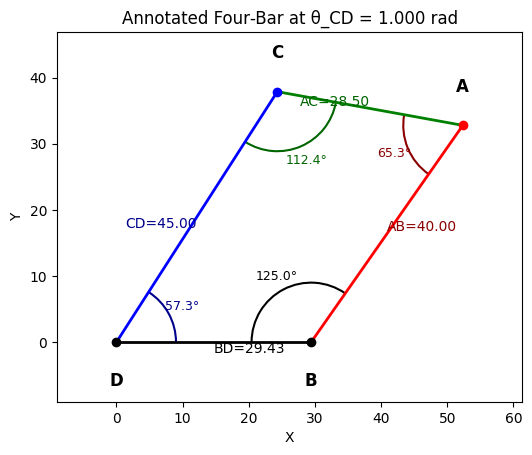

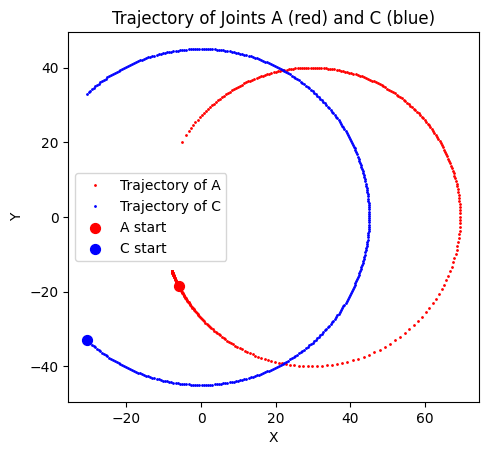

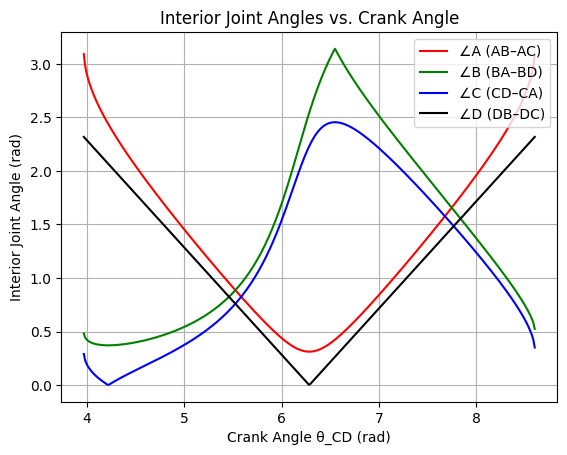

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Interior Joint Angles vs. Crank Angle'}, xlabel='Crank Angle θ_CD (rad)', ylabel='Interior Joint Angle (rad)'>)

In [29]:
L_AB = 40
L_AC = 28.5
L_CD = 45.003
L_BD = 29.428
steps = 360


linkage = FourBarLinkage(L_AB, L_AC, L_CD, L_BD)
print("Linkage type (Grashof test):", linkage.grashof_type())

linkage.annotated_plot(1)
linkage.sweep(n_steps=steps)
linkage.plot_trajectory()
linkage.plot_joint_angles()

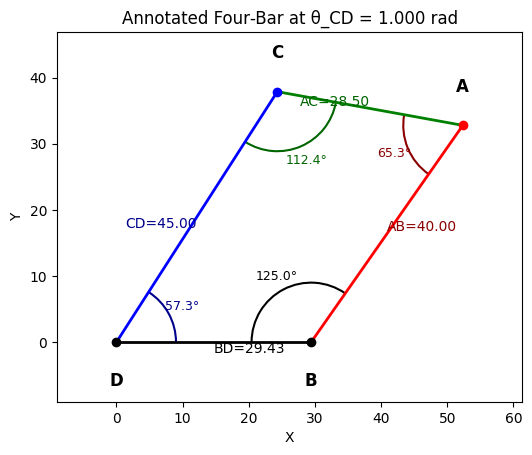

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Annotated Four‐Bar at θ_CD = 1.000 rad'}, xlabel='X', ylabel='Y'>)